# A journey into Convolutional Neural Network visualisation 

There is one famous urban legend about computer vision. Around the 80s, the US military wanted to use neural networks to automatically detect camouflaged enemy tanks. They took a number of pictures of trees without tanks and then pictures with the same trees with tanks behind them.
The results were impressive. So impressive that the army wanted to be sure the net had correctly generalized. They took new pictures of woods with and without tanks and they showed them again to the network. This time, the model performed terribly, it was not able to discriminate between pictures tanks behind woods and just trees. It turned out, that all the pictures with of plain woods were taken on a cloudy day while the ones with tanks on a sunny day! In reality, the network lean to recognize the weather, not the enemy tanks.

With this article we are going to see different techiniques to *understand* what it is going on inside a Convolutional Neural Network to making the same mistake made, ipotetically, by the US army.

The structure is the following:
 - Introduction of the most used techniques
 - Visualisation of common neural networks
 - Visualisation of uncommon neural networks
 - Conclusion
 
We are going to use [Pytorch](https://pytorch.org/) and not Tensorflow since Pytorch is  better framework under all aspects, providing good practice a well written documentation, two main features the Google is missing. All the code can be found [here](https://github.com/FrancescoSaverioZuppichini/A-journey-into-Convolutional-Neural-Network-visualization-), the visualisations are taken from an other [repo](https://github.com/FrancescoSaverioZuppichini/cnn-visualisations). 

We are going to analise two differnt sets of model, classic and unusual. The classic models are the normal backbones used in computer vision:
 - alexnet
 - vgg16
 - resnet (with and without bottleneck)
 - SENet

The second sets are models trained on a very specific missions:
 - U-net for cancer
 - A cnn used in robot task
 
Our goal is to use visualisations techniques to highline and discover differnt aspect of this models. For example, which features is used to understand that a image contains a cat? 

# Classic models
Let's start our journey by selecting some images to be used as inputs. We are first going to fire up `alexnet` and introducing each visualisation techniques. After than we are going to explore the difference between the *classic* models

In [42]:
from torchvision.models import alexnet

model = alexnet(pretrained=True)
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=4096, out_feature

Now we need some inputs

In [27]:
%matplotlib notebook

In [102]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import torch 

from PIL import Image

In [155]:
def tensor2img(tensor, ax=plt):
    tensor = tensor.squeeze()
    if len(tensor.shape) > 2: tensor = tensor.permute(1, 2, 0)
    img = tensor.detach().cpu().numpy()
    return img

In [190]:
def subplot(images, parse=lambda x: x, *args, **kwargs):
    fig, ax = plt.subplots(*args, **kwargs)
    i = 0
    for row in ax:
        try:
            for col in row:
                col.imshow(parse(images[i]))
                col.axis('off')
                i += 1
        except TypeError:
            row.imshow(parse(images[i]))
            row.axis('off')
            i += 1
        except IndexError:
            break
    plt.subplots_adjust(wspace=0, hspace=0)


<IPython.core.display.Javascript object>


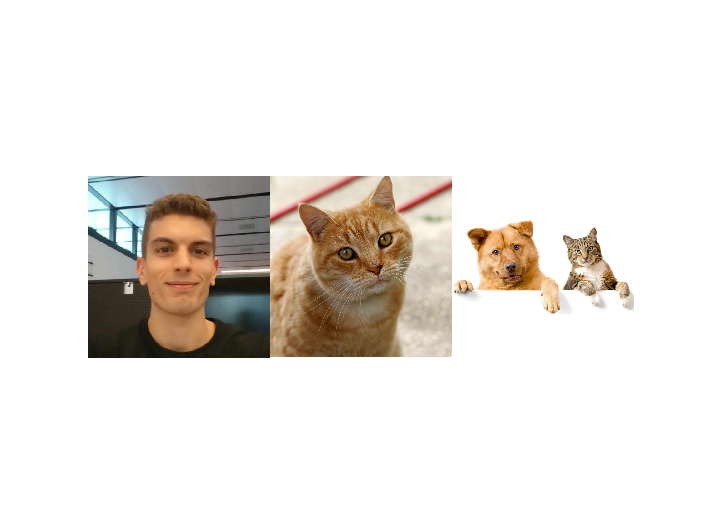

In [192]:
import glob
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image

image_paths = glob.glob('./images/*.*')

images = list(map(lambda x: Image.open(x), image_paths))

subplot(images, nrows=1, ncols=3)

plt.show()

In [149]:
from torchvision.transforms import ToTensor, Resize, Compose

inputs  = [Compose([Resize((224,224)), ToTensor()])(x).unsqueeze(0) for x in images]  # add 1 dim for batch

# Weights Visualisation
The first straightfoward visualisation is to just plot the weigths of a target Layer. Obsviously, the deeper we go the smaller each the image becomes while the channels number increases. We are going to show each channel as a grey array image. Unfortunately, each Pytorch module can be nested and nested, so to make our code as general as possible we first need to trace each sub-module the input traverse and then store each layer in order

In [165]:
def module2traced(module, inputs):
    handles, modules = [], []
        
    def trace(module, inputs, outputs):
        modules.append(module)
    
    def traverse(module):
        for m in module.children():
            traverse(m)
        is_leaf = len(list(module.children())) == 0
        if is_leaf: handles.append(module.register_forward_hook(trace))
        
    traverse(module)
    
    _ = module(inputs)
    
    [h.remove() for h in handles]
    
    return modules

In [166]:
modules = module2traced(model, inputs[0])

In [167]:
from visualisation.core import *

Let's plot the first layer

In [168]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

vis = Weights(model, device)

<IPython.core.display.Javascript object>


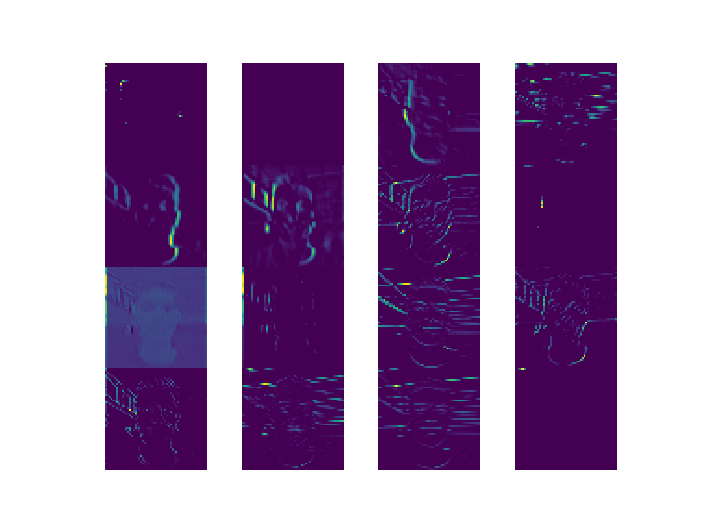

torch.Size([55, 55])
torch.Size([55, 55])
torch.Size([55, 55])
torch.Size([55, 55])
torch.Size([55, 55])
torch.Size([55, 55])
torch.Size([55, 55])
torch.Size([55, 55])
torch.Size([55, 55])
torch.Size([55, 55])
torch.Size([55, 55])
torch.Size([55, 55])
torch.Size([55, 55])
torch.Size([55, 55])
torch.Size([55, 55])
torch.Size([55, 55])


In [193]:
images = vis(inputs[0], modules[0])

images = images[:16]

size = int(np.sqrt(16))

subplot(images, tensor2img, ncols=size, nrows=size)